# Part II

In [1]:
# Library imports
import numpy as np
import random
import matplotlib.pyplot as plt

## 2.1.1 Monte Carlo method with exploring starts (but using ϵ-soft approach)

Starting Monte Carlo with exploring starts (ε-soft policy)...
Optimal Policy with Exploring Starts:
→ ↑ ↑ ← ←
↑ ← ← ← ↑
T ↑ ← ← T
→ ↑ ← ↑ ←
T ↓ ↑ → ↑


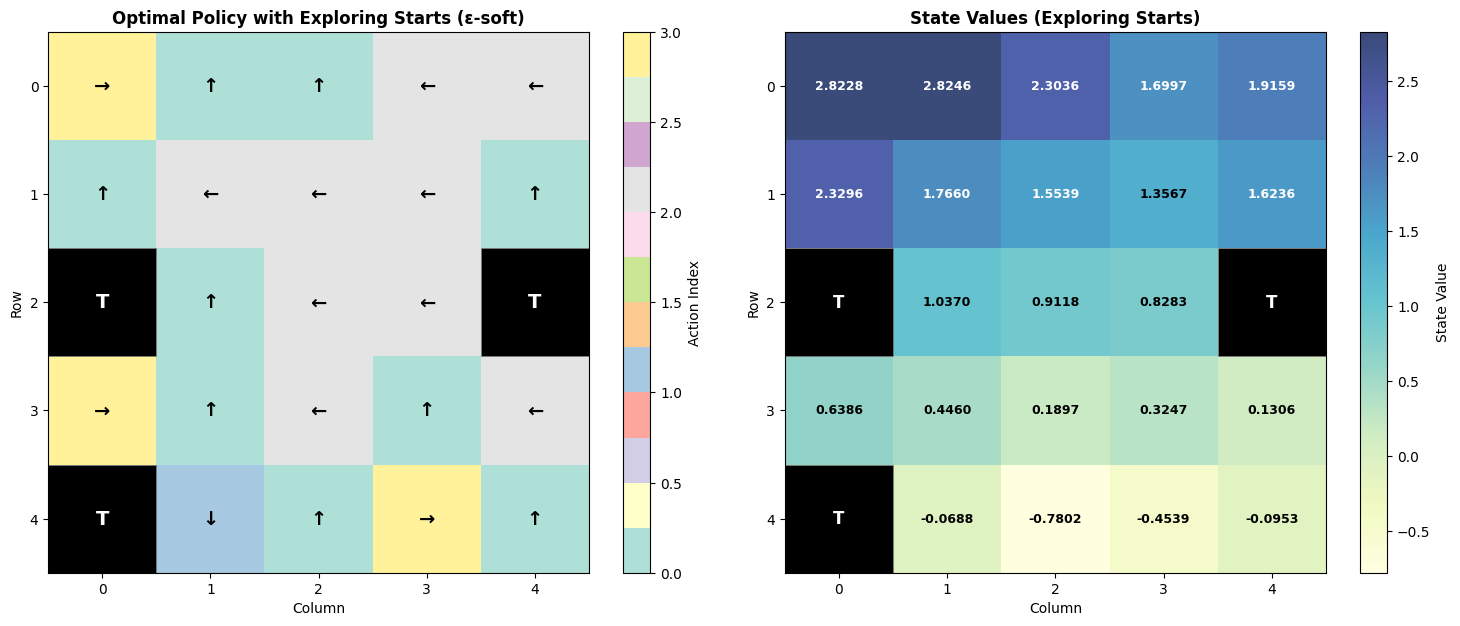


Analysis Results:
Final Q-values for Blue square (0,1): [2.82460368 2.82400647 2.82377983 2.82226209]
Final Q-values for Green square (0,4): [1.84975577 1.46550288 1.91589378 1.75572809]
Final Q-values for Red square (4,2): [-0.78020108 -0.78030483 -0.78164837 -0.83760974]
Final Q-values for Yellow square (4,4): [-0.09529615 -0.36060166 -0.59506229 -0.7189709 ]

Maximum state value: 2.8246
Minimum state value: -0.7802


In [2]:
# Environment setup
grid_size = 5  # 5x5 gridworld
gamma = 0.95  # Discount factor for future rewards
MAX_STEPS = 100  # Maximum number of steps per episode
epsilon = 0.1  # For ε-soft policy

# Define transitions for special squares
transitions = {}
transitions[(0, 1)] = [(5, (4, 2))]   # Blue -> Red
transitions[(0, 4)] = [(2.5, (4, 2)), (2.5, (4, 4))]  # Green -> Red or Yellow

# Define terminal states
terminal_states = [(2, 0), (2, 4), (4, 0)]  # Black squares are terminal states

# Define the four possible actions
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right

np.random.seed(42)  # Set random seed for reproducibility
random.seed(42)

# Function to get the next state and reward
def get_next_state_reward(state, action):
    if state in terminal_states:
        return (0, state)  # No reward, remain in terminal state
    # Handling special transition squares
    if state in transitions:
        transition = transitions[state]
        idx = np.random.choice(len(transition))  # Choose one of the possible transitions
        return transition[idx]
    # Normal movement
    else:
        # Calculate proposed next state
        next_state = (state[0] + action[0], state[1] + action[1])
        # Check if action would take agent off the grid
        if next_state[0] < 0 or next_state[0] >= grid_size or next_state[1] < 0 or next_state[1] >= grid_size:
            return (-0.5, state)  # Penalty for hitting wall, stay in current state
        return (-0.2, next_state)  # Normal move

# Initialize policy and value function
π = np.ones((grid_size, grid_size, len(actions))) / len(actions)  # Equiprobable policy
Q = np.zeros((grid_size, grid_size, len(actions)))  # Initialize action-value function
Returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]  # Store returns for each state-action pair

# Function to generate an episode using exploring starts
def generate_episode(π):
    # Exploring starts: random initial state and action
    S0 = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
    while S0 in terminal_states:  # Ensure we don't start in terminal state
        S0 = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
    A0 = random.choice(actions)

    # Initialize episode storage
    episode = []

    # Set initial state and action
    state = S0
    action = A0
    steps = 0  # Add a step counter to prevent infinite loops

    # Generate episode until terminal state or max steps reached
    while state not in terminal_states and steps < MAX_STEPS:
        # Take action and observe reward and next state
        reward, next_state = get_next_state_reward(state, action)

        # Record the experience (state, action, reward)
        episode.append((state, action, reward))

        state = next_state  # Move to next state
        steps += 1

        # Check if episode ended (reached terminal state)
        if state in terminal_states:
            break

        # Choose next action according to current policy
        action = random.choices(actions, π[state[0], state[1]])[0]

    return episode

# Monte Carlo method with exploring starts (maintained with ε-soft policy)
def monte_carlo_es(π, Q, Returns, num_episodes):
    avg_returns_per_episode = []

    for episode_num in range(num_episodes):
        episode = generate_episode(π)
        G = 0  # Initialize return
        visited = set()  # Track visited state-action pairs

        # Process ALL steps and use correct rewards
        for t in reversed(range(len(episode))):  # Include all steps
            St, At, Rt = episode[t]  # Extract state, action, reward
            G = gamma * G + Rt  # Use current step's reward directly

            # Create state-action pair identifier
            state_action = (St, actions.index(At))

            # Only update if first visit to this state-action pair
            if state_action not in visited:

                # Store return for this state-action pair
                state_index = St[0] * grid_size + St[1]
                Returns[state_index][actions.index(At)].append(G)

                # Update Q-value as average of all returns for this state-action pair
                Q[St[0], St[1], actions.index(At)] = np.mean(Returns[state_index][actions.index(At)])

                # Mark this state-action pair as visited
                visited.add(state_action)

        # Calculate total episode reward correctly
        total_episode_reward = sum([step[2] for step in episode])
        avg_returns_per_episode.append(total_episode_reward)

        # ε-soft policy improvement (instead of pure greedy (initially we have tried))
        for i in range(grid_size):
            for j in range(grid_size):
                if (i, j) not in terminal_states:
                    # Find action with highest Q-value
                    best_action = np.argmax(Q[i, j])
                    # ε-soft policy update
                    for a in range(len(actions)):
                        if a == best_action:
                            π[i, j, a] = 1 - epsilon + (epsilon / len(actions))
                        else:
                            π[i, j, a] = epsilon / len(actions)

    return π, Q

# Perform Monte Carlo with exploring starts
print("Starting Monte Carlo with exploring starts (ε-soft policy)...")
# Run Monte Carlo control algorithm
optimal_policy_es, optimal_Q_es = monte_carlo_es(π, Q, Returns, num_episodes=20000)

# Print the optimal policy using text
action_symbols = {(-1, 0): '↑', (1, 0): '↓', (0, -1): '←', (0, 1): '→'}
print("Optimal Policy with Exploring Starts:")

# Print optimal policy in text format
for i in range(grid_size):
    row = []
    for j in range(grid_size):
        if (i, j) in terminal_states:
            row.append('T')
        else:
            # Find best action for this state
            best_action_idx = np.argmax(optimal_policy_es[i, j])
            best_action = actions[best_action_idx]
            row.append(action_symbols[best_action])
    print(" ".join(row))

# Enhanced visualization (two sub plots) with BLACK terminal states
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Policy visualization
# Create policy grid for visualization (action indices)
policy_grid = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        policy_grid[i, j] = np.argmax(optimal_policy_es[i, j])

# Display policy as colored grid
im1 = ax1.imshow(policy_grid, cmap='Set3', interpolation='nearest', alpha=0.7)
ax1.set_title('Optimal Policy with Exploring Starts (ε-soft)', fontweight='bold')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')

# Adding balck squares for terminal states in policy plot
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) in terminal_states:
            # Drawing black rectangle for terminal state
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='black', edgecolor='gray', linewidth=0.5)
            ax1.add_patch(rect)

# Add action symbols to the plot
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) in terminal_states:
            # Addting white text on black background for terminal states
            ax1.text(j, i, 'T', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
        else:
            best_action_idx = np.argmax(optimal_policy_es[i, j])
            best_action = actions[best_action_idx]
            ax1.text(j, i, action_symbols[best_action], ha='center', va='center', fontsize=14, fontweight='bold')

plt.colorbar(im1, ax=ax1, label='Action Index')

# Plot 2: State values (max Q-value per state)
# Calculate state values (maximum Q-value for each state)
state_values = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) not in terminal_states:
            state_values[i, j] = np.max(optimal_Q_es[i, j])

# Display state values as heatmap
im2 = ax2.imshow(state_values, cmap='YlGnBu', interpolation='nearest', alpha=0.8)
ax2.set_title('State Values (Exploring Starts)', fontweight='bold')
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')

# Adding black squares for terminal states over the heatmap
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) in terminal_states:
            # Draw black rectangle for terminal state
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='black', edgecolor='gray', linewidth=0.5)
            ax2.add_patch(rect)

# Add state values to the plot
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) in terminal_states:
            # WHITE text on BLACK background for terminal states
            ax2.text(j, i, 'T', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
        else:
            ax2.text(j, i, f'{state_values[i, j]:.4f}', ha='center', va='center',
                    fontsize=9, fontweight='bold',
                    color='white' if state_values[i, j] > np.max(state_values)/2 else 'black')

plt.colorbar(im2, ax=ax2, label='State Value')

plt.tight_layout()
plt.show()

print(f"\nAnalysis Results:")
print(f"Final Q-values for Blue square (0,1): {optimal_Q_es[0, 1]}")
print(f"Final Q-values for Green square (0,4): {optimal_Q_es[0, 4]}")
print(f"Final Q-values for Red square (4,2): {optimal_Q_es[4, 2]}")
print(f"Final Q-values for Yellow square (4,4): {optimal_Q_es[4, 4]}")

print(f"\nMaximum state value: {np.max(state_values):.4f}")
print(f"Minimum state value: {np.min(state_values):.4f}")

# 2.2.2 Monte Carlo method **without** exploring starts (but using ϵ-soft approach)

Running Monte Carlo WITHOUT Exploring Starts for different ε values...
Fixed starting state: (0, 0)
Episodes: 20,000

 Running with ε = 0.1...


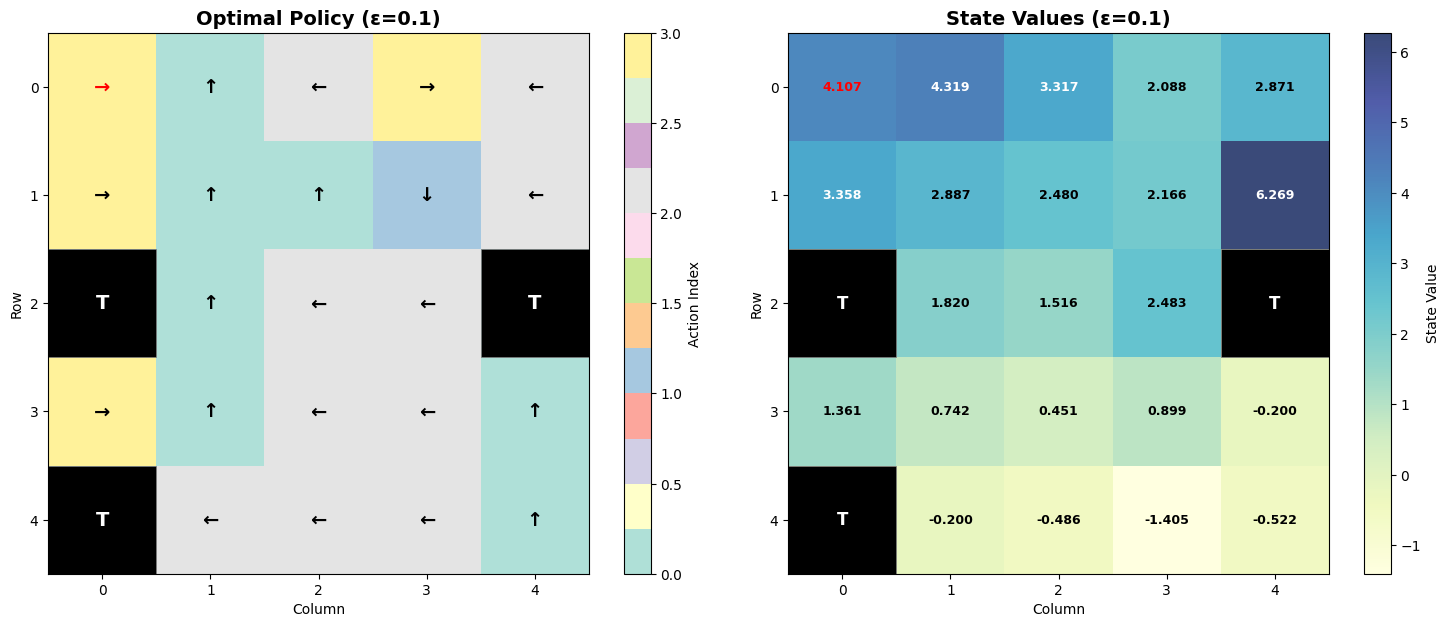


RESULTS FOR ε = 0.1
Optimal Policy:
→ ↑ ← → ←
→ ↑ ↑ ↓ ←
T ↑ ← ← T
→ ↑ ← ← ↑
T ← ← ← ↑

Analysis Results:
Final Q-values for Blue square (0,1): [4.31942456 4.28441677 4.2873335  4.28950485]
Final Q-values for Green square (0,4): [-0.51344308  0.32769315  2.87122614 -0.14230347]
Final Q-values for Red square (4,2): [-0.49839315 -0.49231742 -0.48611633 -1.79186927]
Final Q-values for Yellow square (4,4): [-0.5224013  -3.16736234 -1.3452115  -1.15773519]

Maximum state value: 6.2695
Minimum state value: -1.4055
Blue square value: 4.3194
Green square value: 2.8712

 Running with ε = 0.3...


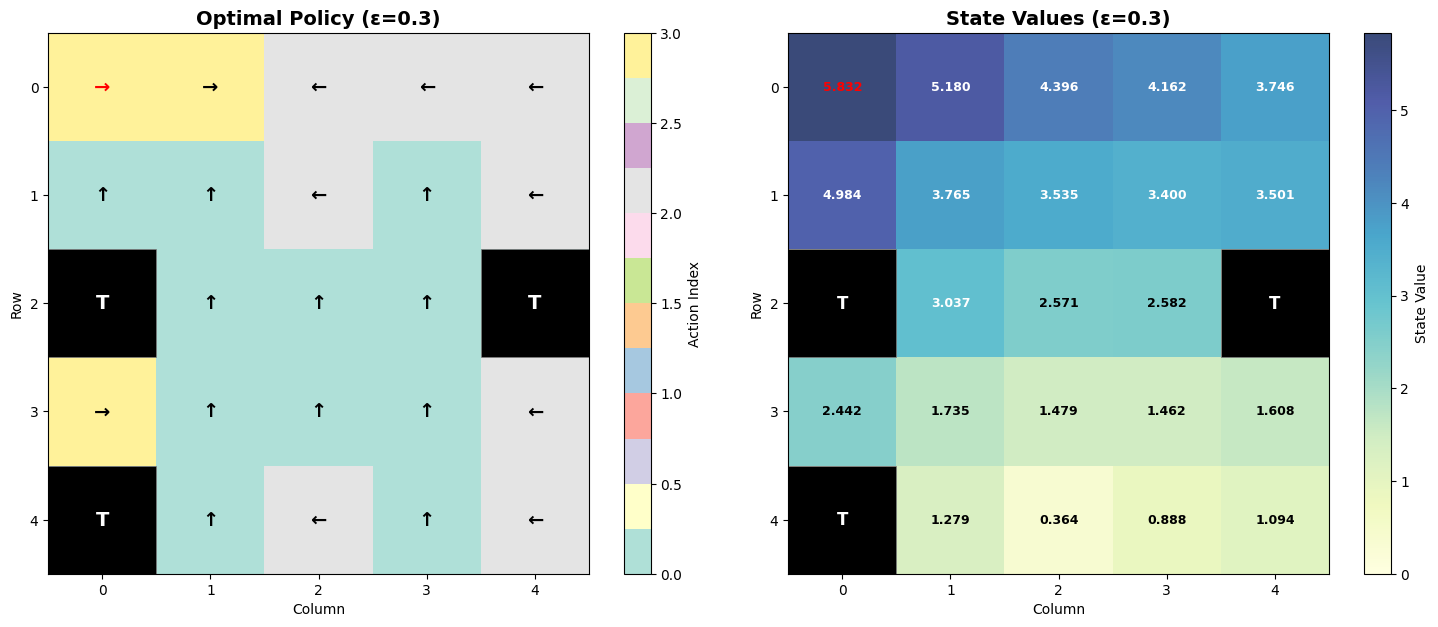


RESULTS FOR ε = 0.3
Optimal Policy:
→ → ← ← ←
↑ ↑ ← ↑ ←
T ↑ ↑ ↑ T
→ ↑ ↑ ↑ ←
T ↑ ← ↑ ←

Analysis Results:
Final Q-values for Blue square (0,1): [5.18003012 5.17992911 5.17967889 5.18010971]
Final Q-values for Green square (0,4): [3.58235981 3.35829123 3.74570004 3.38899609]
Final Q-values for Red square (4,2): [0.36324795 0.36298545 0.36351998 0.36330974]
Final Q-values for Yellow square (4,4): [1.08636788 0.46640661 1.09370748 0.42905397]

Maximum state value: 5.8325
Minimum state value: 0.0000
Blue square value: 5.1801
Green square value: 3.7457

 Running with ε = 0.5...


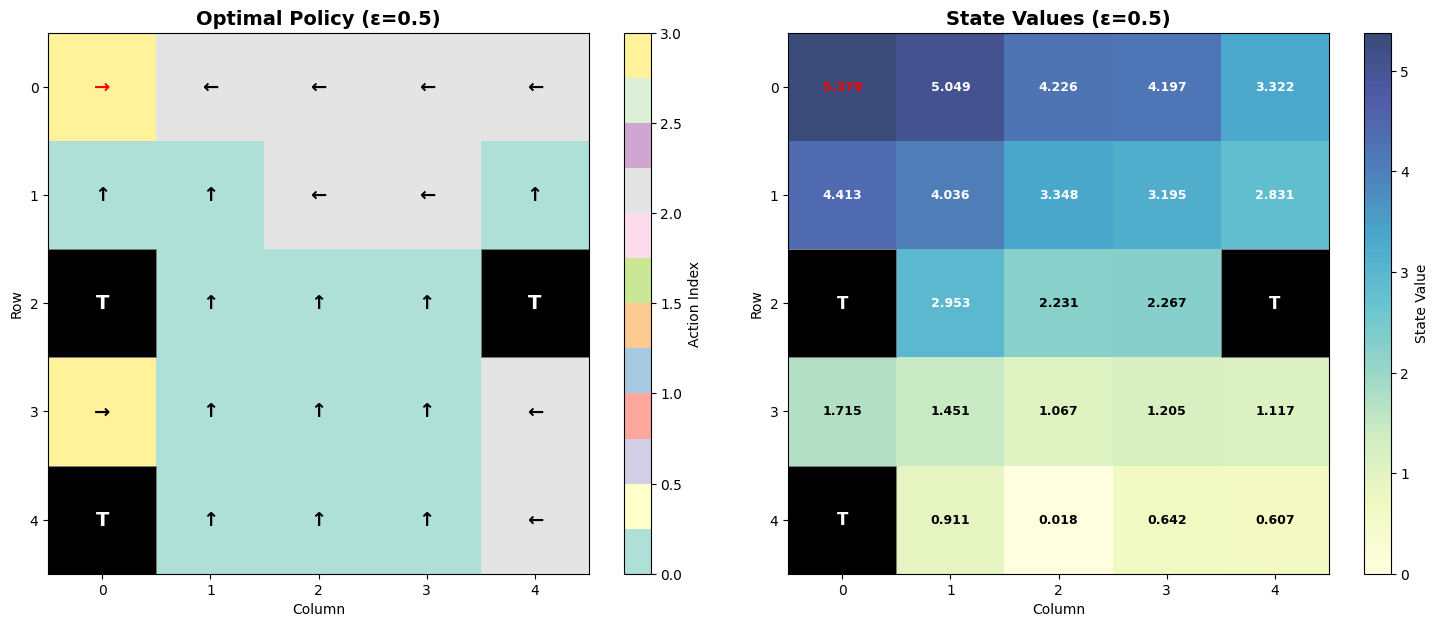


RESULTS FOR ε = 0.5
Optimal Policy:
→ ← ← ← ←
↑ ↑ ← ← ↑
T ↑ ↑ ↑ T
→ ↑ ↑ ↑ ←
T ↑ ↑ ↑ ←

Analysis Results:
Final Q-values for Blue square (0,1): [5.04901048 5.04890437 5.04920824 5.04878726]
Final Q-values for Green square (0,4): [3.20165566 3.19100199 3.32176263 3.17054597]
Final Q-values for Red square (4,2): [0.01830952 0.01779303 0.01681698 0.01637984]
Final Q-values for Yellow square (4,4): [ 0.38844325 -0.09016909  0.60707034 -0.10761716]

Maximum state value: 5.3785
Minimum state value: 0.0000
Blue square value: 5.0492
Green square value: 3.3218

 Running with ε = 0.7...


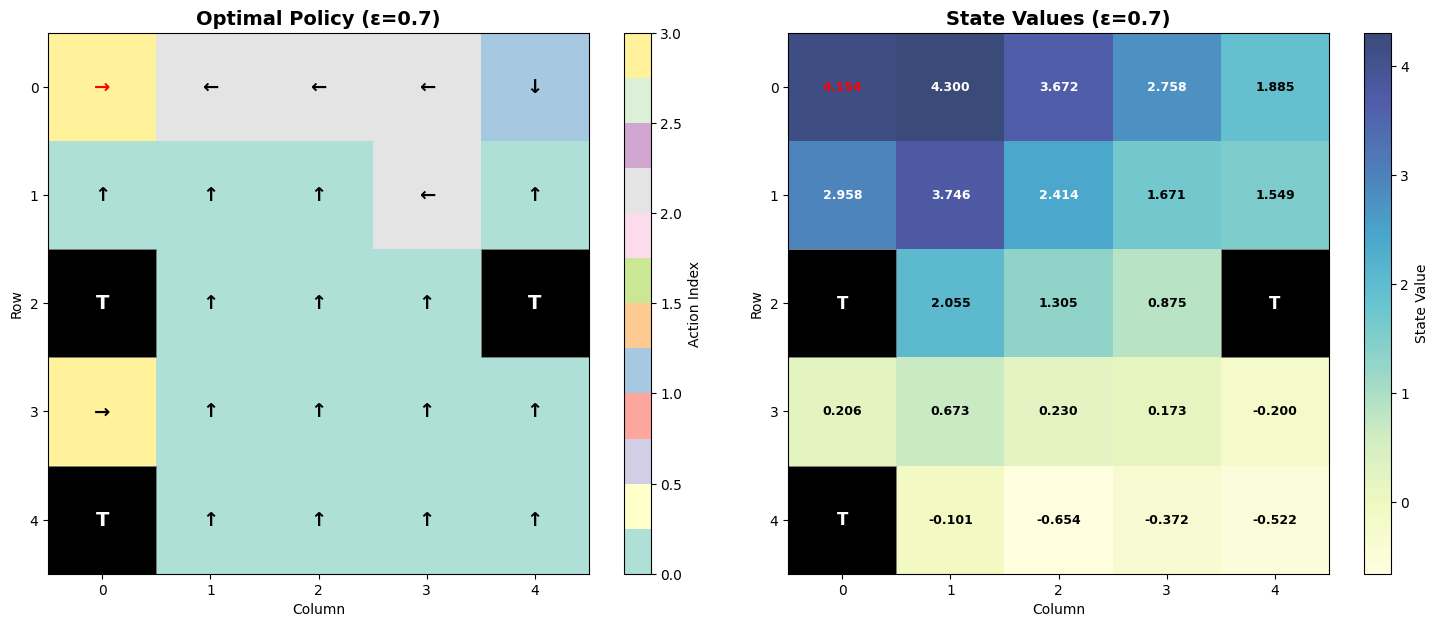


RESULTS FOR ε = 0.7
Optimal Policy:
→ ← ← ← ↓
↑ ↑ ↑ ← ↑
T ↑ ↑ ↑ T
→ ↑ ↑ ↑ ↑
T ↑ ↑ ↑ ↑

Analysis Results:
Final Q-values for Blue square (0,1): [4.29946339 4.29967482 4.2999674  4.29926822]
Final Q-values for Green square (0,4): [1.87521748 1.88542147 1.86239573 1.82943205]
Final Q-values for Red square (4,2): [-0.65365977 -0.91602016 -0.6538768  -0.97762884]
Final Q-values for Yellow square (4,4): [-0.52172837 -1.20783027 -0.73358059 -1.15178983]

Maximum state value: 4.3000
Minimum state value: -0.6537
Blue square value: 4.3000
Green square value: 1.8854

 Running with ε = 0.8...


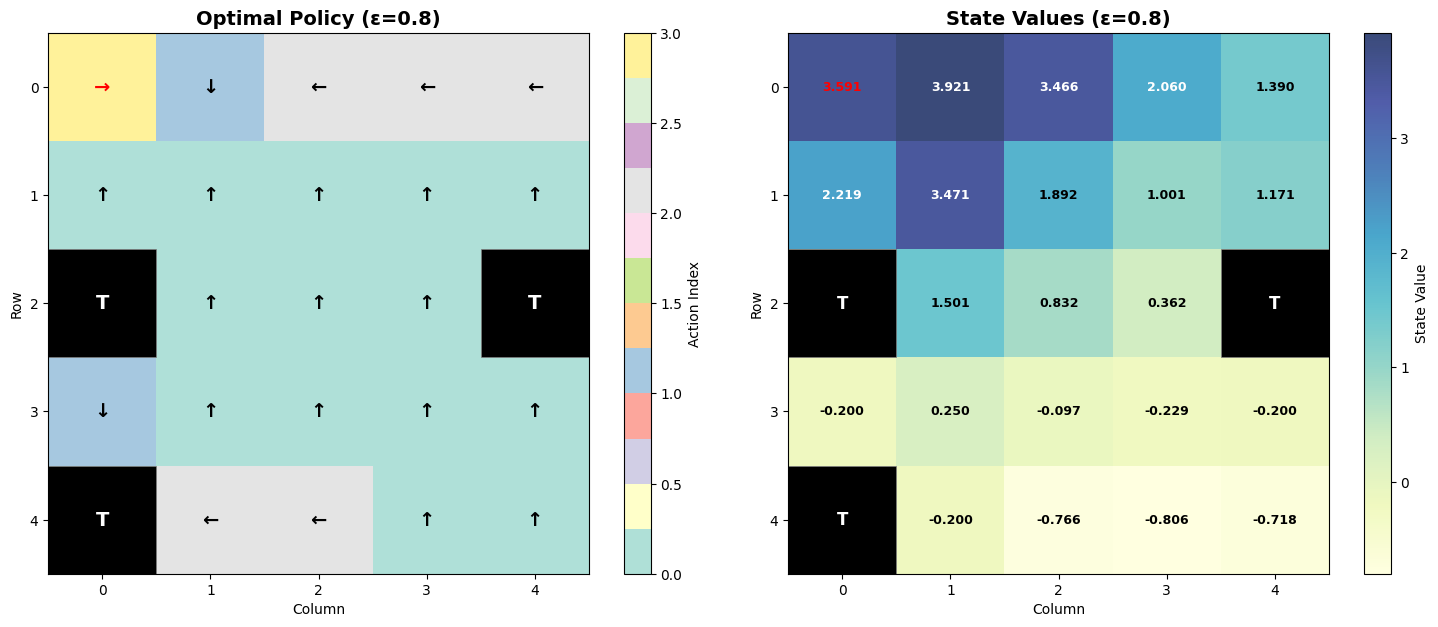


RESULTS FOR ε = 0.8
Optimal Policy:
→ ↓ ← ← ←
↑ ↑ ↑ ↑ ↑
T ↑ ↑ ↑ T
↓ ↑ ↑ ↑ ↑
T ← ← ↑ ↑

Analysis Results:
Final Q-values for Blue square (0,1): [3.9204302  3.92094446 3.91988726 3.91206274]
Final Q-values for Green square (0,4): [1.30011044 1.35523516 1.39004436 1.33896494]
Final Q-values for Red square (4,2): [-0.8182227  -1.34697275 -0.76581278 -1.35682938]
Final Q-values for Yellow square (4,4): [-0.71751773 -1.4716446  -1.2312131  -1.48929503]

Maximum state value: 3.9209
Minimum state value: -0.8056
Blue square value: 3.9209
Green square value: 1.3900

 Running with ε = 0.9...


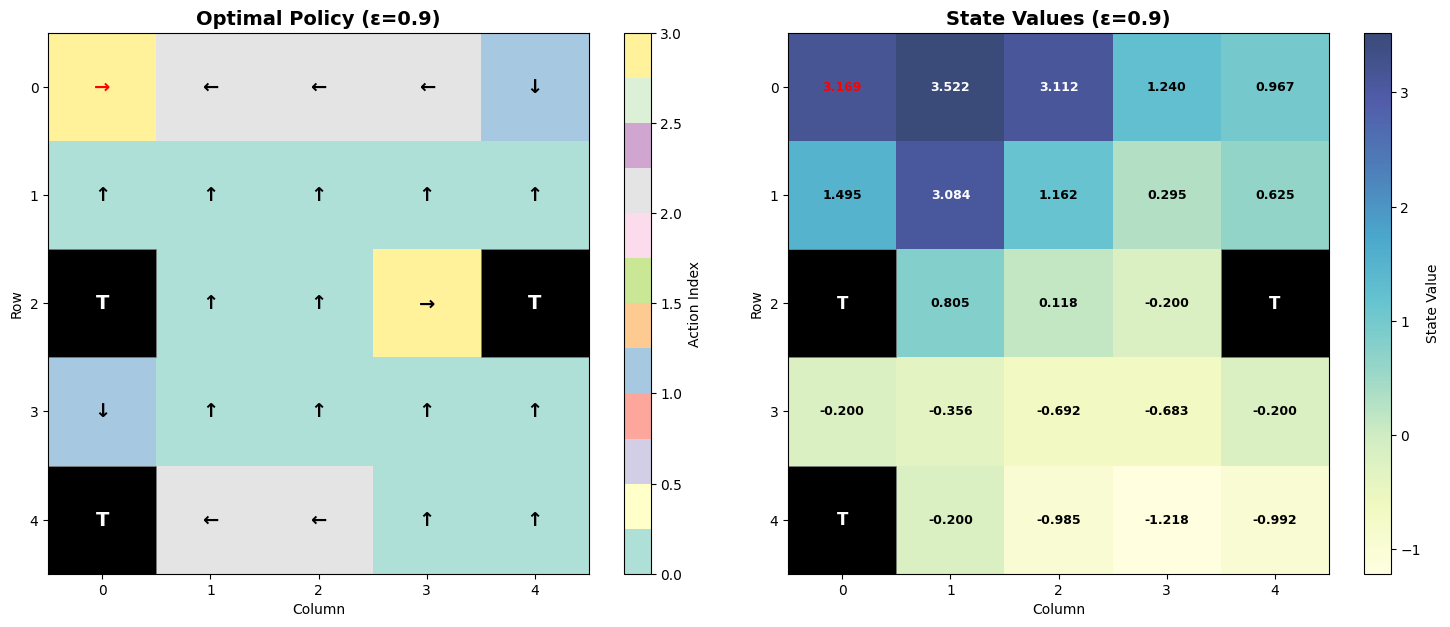


RESULTS FOR ε = 0.9
Optimal Policy:
→ ← ← ← ↓
↑ ↑ ↑ ↑ ↑
T ↑ ↑ → T
↓ ↑ ↑ ↑ ↑
T ← ← ↑ ↑

Analysis Results:
Final Q-values for Blue square (0,1): [3.52002828 3.50612722 3.52208198 3.50556654]
Final Q-values for Green square (0,4): [0.82105615 0.96734019 0.8788665  0.88722472]
Final Q-values for Red square (4,2): [-1.25920531 -1.698899   -0.98489586 -1.73635732]
Final Q-values for Yellow square (4,4): [-0.99171379 -1.83871006 -1.60572891 -1.83036703]

Maximum state value: 3.5221
Minimum state value: -1.2177
Blue square value: 3.5221
Green square value: 0.9673


In [3]:
# Environment setup
grid_size = 5  # 5x5 gridworld
gamma = 0.95  # Discount factor for future rewards
MAX_STEPS = 100  # Maximum number of steps per episode

# Define transitions for special squares
transitions = {}
transitions[(0, 1)] = [(5, (4, 2))]   # Blue -> Red
transitions[(0, 4)] = [(2.5, (4, 2)), (2.5, (4, 4))]  # Green -> Red or Yellow

# Define terminal states
terminal_states = [(2, 0), (2, 4), (4, 0)]  # Black squares are terminal states

# Define the four possible actions
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right

# Function to get the next state and reward
def get_next_state_reward(state, action):
    if state in terminal_states:
        return (0, state)  # No reward, remain in terminal state
    # Handling special transition squares
    if state in transitions:
        transition = transitions[state]
        idx = np.random.choice(len(transition))  # Choose one of the possible transitions
        return transition[idx]
    # Normal movement
    else:
        # Calculate proposed next state
        next_state = (state[0] + action[0], state[1] + action[1])
        # Check if action would take agent off the grid
        if next_state[0] < 0 or next_state[0] >= grid_size or next_state[1] < 0 or next_state[1] >= grid_size:
            return (-0.5, state)  # Penalty for hitting wall, stay in current state
        return (-0.2, next_state)  # Normal move

# Function to generate an episode without exploring starts
def generate_episode(π):
    S0 = (0, 0)  # Always start from top-left corner
    episode = []
    state = S0
    steps = 0

    while state not in terminal_states and steps < MAX_STEPS:
        action = random.choices(actions, π[state[0], state[1]])[0]
        reward, next_state = get_next_state_reward(state, action)
        episode.append((state, action, reward))
        state = next_state
        steps += 1
        if state in terminal_states:
            break

    return episode

# Monte Carlo method WITHOUT exploring starts (ε-soft policy)
def monte_carlo_eps_soft(epsilon, num_episodes=20000):
    # Initialize for each epsilon run
    np.random.seed(42)  # Reset seed for consistent comparison
    random.seed(42)

    π = np.ones((grid_size, grid_size, len(actions))) / len(actions)  # Equiprobable policy
    Q = np.zeros((grid_size, grid_size, len(actions)))  # Initialize action-value function
    Returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]

    for episode_num in range(num_episodes):
        episode = generate_episode(π)
        G = 0
        visited = set()

        # Process episode backwards
        for t in reversed(range(len(episode))):
            St, At, Rt = episode[t]
            G = gamma * G + Rt
            state_action = (St, actions.index(At))

            if state_action not in visited:
                state_index = St[0] * grid_size + St[1]
                Returns[state_index][actions.index(At)].append(G)
                Q[St[0], St[1], actions.index(At)] = np.mean(Returns[state_index][actions.index(At)])
                visited.add(state_action)

        # ε-soft policy improvement
        for i in range(grid_size):
            for j in range(grid_size):
                if (i, j) not in terminal_states:
                    best_action = np.argmax(Q[i, j])
                    for a in range(len(actions)):
                        if a == best_action:
                            π[i, j, a] = 1 - epsilon + (epsilon / len(actions))
                        else:
                            π[i, j, a] = epsilon / len(actions)

    return π, Q

# Function to create visualization for a given epsilon
def create_visualization(epsilon, policy, Q, figure_num):
    action_symbols = {(-1, 0): '↑', (1, 0): '↓', (0, -1): '←', (0, 1): '→'}

    # Calculate state values
    state_values = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) not in terminal_states:
                state_values[i, j] = np.max(Q[i, j])

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Policy visualization
    policy_grid = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            policy_grid[i, j] = np.argmax(policy[i, j])

    im1 = ax1.imshow(policy_grid, cmap='Set3', interpolation='nearest', alpha=0.7)
    ax1.set_title(f'Optimal Policy (ε={epsilon})', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')

    # Add BLACK squares for terminal states
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in terminal_states:
                rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='black', edgecolor='gray', linewidth=0.5)
                ax1.add_patch(rect)

    # Add action symbols
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in terminal_states:
                ax1.text(j, i, 'T', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
            else:
                best_action_idx = np.argmax(policy[i, j])
                best_action = actions[best_action_idx]
                color = 'red' if (i, j) == (0, 0) else 'black'
                ax1.text(j, i, action_symbols[best_action], ha='center', va='center',
                        fontsize=14, fontweight='bold', color=color)

    plt.colorbar(im1, ax=ax1, label='Action Index')

    # Plot 2: State values
    im2 = ax2.imshow(state_values, cmap='YlGnBu', interpolation='nearest', alpha=0.8)
    ax2.set_title(f'State Values (ε={epsilon})', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')

    # Add BLACK squares for terminal states
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in terminal_states:
                rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='black', edgecolor='gray', linewidth=0.5)
                ax2.add_patch(rect)

    # Add state values text
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in terminal_states:
                ax2.text(j, i, 'T', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
            else:
                color = 'red' if (i, j) == (0, 0) else ('white' if state_values[i, j] > np.max(state_values)/2 else 'black')
                ax2.text(j, i, f'{state_values[i, j]:.3f}', ha='center', va='center',
                        fontsize=9, fontweight='bold', color=color)

    plt.colorbar(im2, ax=ax2, label='State Value')
    plt.tight_layout()
    plt.show()

    return state_values

# Function to print results for each epsilon
def print_results(epsilon, policy, Q, state_values):
    action_symbols = {(-1, 0): '↑', (1, 0): '↓', (0, -1): '←', (0, 1): '→'}

    print(f"\n{'='*60}")
    print(f"RESULTS FOR ε = {epsilon}")
    print(f"{'='*60}")

    print("Optimal Policy:")
    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            if (i, j) in terminal_states:
                row.append('T')
            else:
                best_action_idx = np.argmax(policy[i, j])
                best_action = actions[best_action_idx]
                row.append(action_symbols[best_action])
        print(" ".join(row))

    print(f"\nAnalysis Results:")
    print(f"Final Q-values for Blue square (0,1): {Q[0, 1]}")
    print(f"Final Q-values for Green square (0,4): {Q[0, 4]}")
    print(f"Final Q-values for Red square (4,2): {Q[4, 2]}")
    print(f"Final Q-values for Yellow square (4,4): {Q[4, 4]}")

    print(f"\nMaximum state value: {np.max(state_values):.4f}")
    print(f"Minimum state value: {np.min(state_values):.4f}")
    print(f"Blue square value: {np.max(Q[0, 1]):.4f}")
    print(f"Green square value: {np.max(Q[0, 4]):.4f}")

# Main execution
if __name__ == "__main__":
    # Define epsilon values to test
    epsilon_values = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9]

    # Store results for comparison
    results_summary = []

    print("Running Monte Carlo WITHOUT Exploring Starts for different ε values...")
    print("Fixed starting state: (0, 0)")
    print("Episodes: 20,000")

    for i, eps in enumerate(epsilon_values):
        print(f"\n Running with ε = {eps}...")

        # Run Monte Carlo for current epsilon
        optimal_policy, optimal_Q = monte_carlo_eps_soft(eps)

        # Create visualization
        state_values = create_visualization(eps, optimal_policy, optimal_Q, i+1)

        # Print detailed results
        print_results(eps, optimal_policy, optimal_Q, state_values)

        # Store summary for comparison
        max_val = np.max(state_values)
        blue_val = np.max(optimal_Q[0, 1])
        green_val = np.max(optimal_Q[0, 4])
        results_summary.append({
            'epsilon': eps,
            'max_state_value': max_val,
            'blue_value': blue_val,
            'green_value': green_val
        })


# 2.2  Behaviour Policy with Equiprobable moves to Learn an Optimal Policy

Starting Monte Carlo with Importance Sampling...
Behavior policy: Equiprobable (uniform)
Target policy: Greedy (deterministic)
Episode 5000: Average Q-value = -0.2231
Episode 10000: Average Q-value = -0.2474
Episode 15000: Average Q-value = -0.2600
Episode 20000: Average Q-value = -0.2652
Episode 25000: Average Q-value = -0.2692
Episode 30000: Average Q-value = -0.2622
Episode 35000: Average Q-value = -0.2819
Episode 40000: Average Q-value = -0.2836
Episode 45000: Average Q-value = 0.0397
Episode 50000: Average Q-value = 0.1256
Episode 55000: Average Q-value = 0.2106
Episode 60000: Average Q-value = 0.2041
Episode 65000: Average Q-value = 0.2440
Episode 70000: Average Q-value = 0.2431
Episode 75000: Average Q-value = 0.2771
Episode 80000: Average Q-value = 0.2771
Episode 85000: Average Q-value = 0.2659
Episode 90000: Average Q-value = 0.2572
Episode 95000: Average Q-value = 0.2572
Episode 100000: Average Q-value = 0.2441
Episode 105000: Average Q-value = 0.6403
Episode 110000: Average 

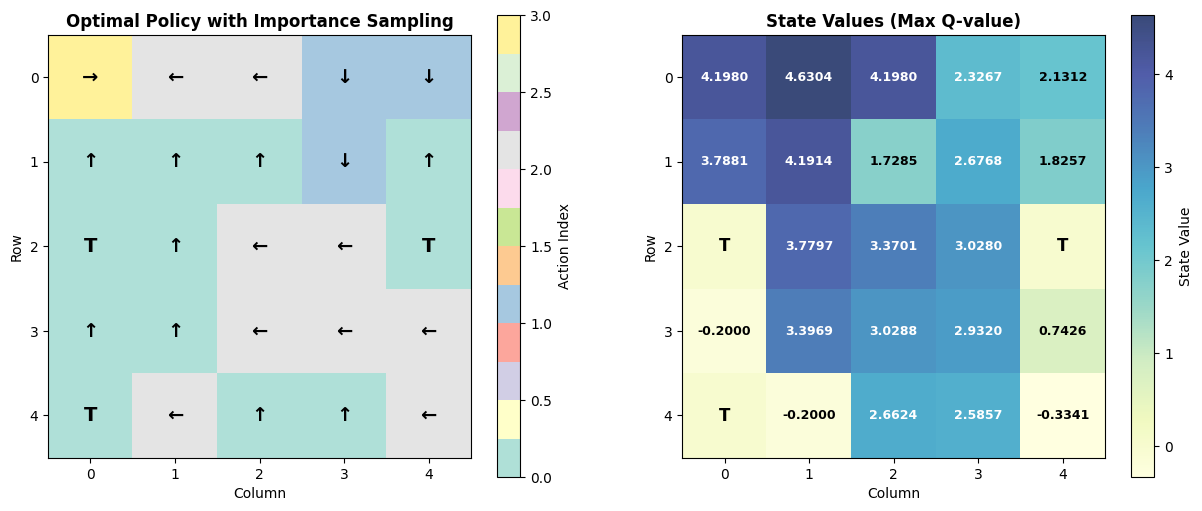

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Environment setup
# Define the gridworld size and discount factor

grid_size = 5 # 5x5 gridworld
gamma = 0.95 # Discount factor for future rewards
MAX_STEPS = 100 # Maximum number of steps per episode (prevents infinite loops)

# Define transitions for special squares
transitions = {}
transitions[(0, 1)] = [(5, (4, 2))]   # Blue -> Red
transitions[(0, 4)] = [(2.5, (4, 2)), (2.5, (4, 4))]  # Green -> Red or Yellow

# Define terminal states (black squares where episodes end)
terminal_states = [(2, 0), (2, 4), (4, 0)]

# Define the four possible actions (up, down, left, right)
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Function to get the next state and reward
def get_next_state_reward(state, action):

    # If already in terminal state, stay there with no reward
    if state in terminal_states:
        return (0, state)

    # Handle special transition squares (Blue and Green)
    if state in transitions:
        transition = transitions[state]
        # Randomly choose one of the possible transitions
        idx = np.random.choice(len(transition))
        return transition[idx]
    # Normal movement
    else:
        # Calculate proposed next state
        next_state = (state[0] + action[0], state[1] + action[1])

        # Check if action would take agent off the grid
        if next_state[0] < 0 or next_state[0] >= grid_size or next_state[1] < 0 or next_state[1] >= grid_size:
            return (-0.5, state)  # Stepping off the grid
        return (-0.2, next_state)  # Normal move

# Initialize behavior policy (equiprobable) and target policy
behavior_policy = np.ones((grid_size, grid_size, len(actions))) / len(actions)  # Equiprobable behavior policy
target_policy = np.zeros((grid_size, grid_size, len(actions)))  # Target policy (deterministic)
Q = np.zeros((grid_size, grid_size, len(actions)))  # Action-value function
C = np.zeros((grid_size, grid_size, len(actions)))  # Cumulative weights for importance sampling

# Initialize target policy randomly but deterministically
# Each state gets exactly one action with probability 1, others with probability 0
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) not in terminal_states:
            # Randomly choose an action to be the initial "best" action
            best_action = np.random.choice(len(actions))
            # Set policy to be deterministic: chosen action gets prob 1, others get prob 0
            target_policy[i, j] = np.eye(len(actions))[best_action]

# Function to generate an episode using behavior policy
def generate_episode_behavior(behavior_policy):

    # Ensure starting from non-terminal state
    state = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
    # Ensure we don't start in a terminal state
    while state in terminal_states:
        state = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))

    # Initialize episode storage
    episode = []
    steps = 0 # Step counter to prevent infinite loops

    # Generate episode using BEHAVIOR policy until terminal state or max steps
    while state not in terminal_states and steps < MAX_STEPS:
        action = random.choices(actions, behavior_policy[state[0], state[1]])[0]  # Choose action according to BEHAVIOR policy (uniform random)
        reward, next_state = get_next_state_reward(state, action) # Take action and observe reward and next state
        episode.append((state, action, reward))  # Record the experience (state, action, reward)
        state = next_state # Move to next state
        steps += 1 # Increment step counter

    return episode

# Monte Carlo with importance sampling (Use behavior policy)
def monte_carlo_importance_sampling(target_policy, behavior_policy, Q, C, num_episodes):

    for episode_num in range(num_episodes):
        # Generate episode using behavior policy
        episode = generate_episode_behavior(behavior_policy)

        G = 0  # Initialize return
        W = 1  # Initialize importance sampling weight

        # Process episode backwards
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t] # Extract state, action, reward
            G = gamma * G + reward # Update return with current reward (standard return calculation)
            action_idx = actions.index(action) # Get action index

            # Update cumulative weights (sum of importance weights)
            C[state[0], state[1], action_idx] += W

            # Proper weighted incremental averaging (This gives more weight to returns with higher importance sampling ratios)
            if C[state[0], state[1], action_idx] > 0:
                Q[state[0], state[1], action_idx] += (W / C[state[0], state[1], action_idx]) * (G - Q[state[0], state[1], action_idx])

            # Update target policy to be greedy with respect to current Q-values
            best_action = np.argmax(Q[state[0], state[1]])
            # target policy deterministic: best action gets prob 1, others get prob 0
            target_policy[state[0], state[1]] = np.eye(len(actions))[best_action]

            # Calculate importance sampling weight for NEXT iteration
            target_prob = target_policy[state[0], state[1], action_idx]
            behavior_prob = behavior_policy[state[0], state[1], action_idx]

            # Check for zero probability BEFORE updating weight (checks to prevent division by zero and invalid ratios)
            if behavior_prob == 0:
                break  # Avoid division by zero

            if target_prob == 0:
                break  # If target policy would never take this action, terminate

            # Update importance sampling weight
            W *= target_prob / behavior_prob

        # Print progress
        if (episode_num + 1) % 5000 == 0:
            avg_q = np.mean(Q[Q != 0])
            print(f"Episode {episode_num + 1}: Average Q-value = {avg_q:.4f}")

    return target_policy, Q

# Perform Monte Carlo with importance sampling
print("Starting Monte Carlo with Importance Sampling...")
print("Behavior policy: Equiprobable (uniform)")
print("Target policy: Greedy (deterministic)")
# num_episodes=20000 - - changed from 20000 to 100000 (since off-policy learning is failing at 20000 episodes)
optimal_policy_is, optimal_Q_is = monte_carlo_importance_sampling(target_policy, behavior_policy, Q, C, num_episodes=200000)

print("\nTraining completed!")

# Print the optimal policy using text
action_symbols = {(-1, 0): '↑', (1, 0): '↓', (0, -1): '←', (0, 1): '→'}
print("Optimal Policy with Importance Sampling:")
for i in range(grid_size):
    row = []
    for j in range(grid_size):
        if (i, j) in terminal_states:
            row.append('T')
        else:
            # Find best action for this state in target policy
            best_action_idx = np.argmax(optimal_policy_is[i, j])
            best_action = actions[best_action_idx]
            row.append(action_symbols[best_action])
    print(" ".join(row))

# Enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Policy visualization
policy_grid = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        policy_grid[i, j] = np.argmax(optimal_policy_is[i, j])

# Display policy as colored grid
im1 = ax1.imshow(policy_grid, cmap='Set3', interpolation='nearest', alpha=0.7)
ax1.set_title('Optimal Policy with Importance Sampling', fontweight='bold')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')

# Add action symbols to the plot
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) in terminal_states:
            ax1.text(j, i, 'T', ha='center', va='center', fontsize=14, fontweight='bold', color='black')
        else:
            best_action_idx = np.argmax(optimal_policy_is[i, j])
            best_action = actions[best_action_idx]
            ax1.text(j, i, action_symbols[best_action], ha='center', va='center', fontsize=14, fontweight='bold')

plt.colorbar(im1, ax=ax1, label='Action Index')

# Plot 2: State values (max Q-value per state)
state_values = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) not in terminal_states:
            state_values[i, j] = np.max(optimal_Q_is[i, j])

# Display state values as heatmap
im2 = ax2.imshow(state_values, cmap='YlGnBu', interpolation='nearest', alpha=0.8)
ax2.set_title('State Values (Max Q-value)', fontweight='bold')
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')

for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) in terminal_states:
            ax2.text(j, i, 'T', ha='center', va='center', fontsize=12, fontweight='bold', color='black')
        else:
            ax2.text(j, i, f'{state_values[i, j]:.4f}', ha='center', va='center',
                    fontsize=9, fontweight='bold',
                    color='white' if state_values[i, j] > np.max(state_values)/2 else 'black')

plt.colorbar(im2, ax=ax2, label='State Value')

# Print detailed statistics
print(f"\nDetailed Statistics:")
print(f"Final Q-values for Blue square (0,1): {optimal_Q_is[0, 1]}")
print(f"Final Q-values for Green square (0,4): {optimal_Q_is[0, 4]}")
print(f"Final Q-values for Red square (4,2): {optimal_Q_is[4, 2]}")
print(f"Final Q-values for Yellow square (4,4): {optimal_Q_is[4, 4]}")

print(f"\nPolicy determinism check (should all be 1.0):")
for i in range(grid_size):
    for j in range(grid_size):
        if (i, j) not in terminal_states:
            max_prob = np.max(optimal_policy_is[i, j])
            if max_prob < 0.99:  # Flag non-deterministic policies
                print(f"  State ({i},{j}): {max_prob:.3f}")

print(f"\nMaximum state value: {np.max(state_values):.4f}")
print(f"Total cumulative weight: {np.sum(C):.2f}")